# 1. Análisis Exploratorio y Clustering (EDA)
Este notebook realiza el análisis inicial de los datos, detecta outliers, revisa distribuciones y segmenta las tiendas en grupos según su comportamiento.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
import sys
import os

# Agregar path para importar módulos locales
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import kagglehub

## 1. Carga de Datos
Descargamos los datos frescos usando la API.

In [3]:
# Descarga el dataset desde Kaggle usando KaggleHub (si ya existe, lo reutiliza)
path = kagglehub.dataset_download("jaklinmalkoc/predict-future-sales-retail-dataset-en")

# Carga de archivos principales
sales = pd.read_csv(os.path.join(path, "sales_train.csv"))
items = pd.read_csv(os.path.join(path, "items.csv"))
shops = pd.read_csv(os.path.join(path, "shops.csv"))

# Conversión de fechas al formato datetime (día/mes/año)
sales["date"] = pd.to_datetime(sales["date"], dayfirst=True)

# Dimensión del dataset de ventas
print(f"Registros de ventas: {sales.shape}")

Registros de ventas: (600, 6)


## 2. Detección de Outliers (Limpieza)
Identificamos ventas y precios extremos que pueden dañar el modelo.

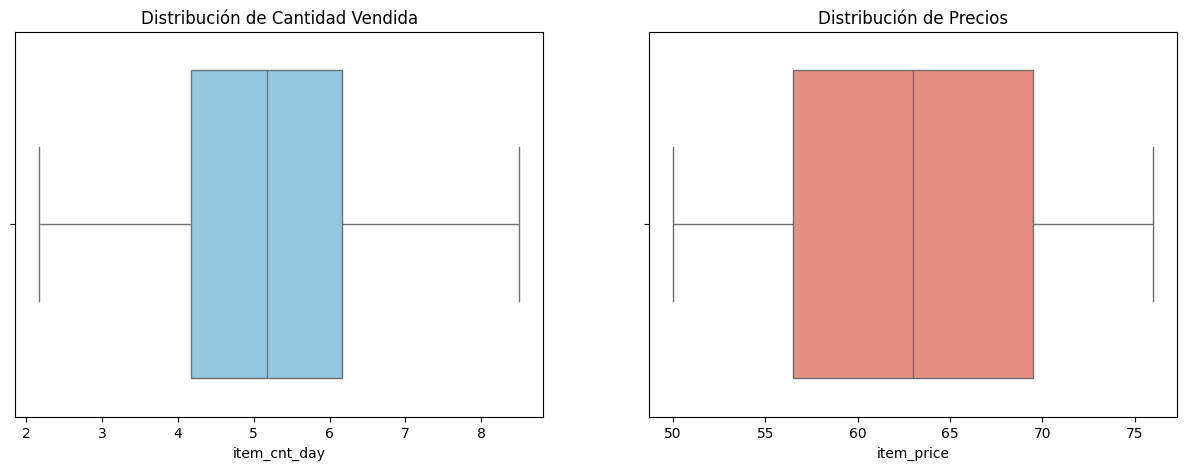

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Boxplot de cantidades vendidas (detección visual de valores atípicos)
sns.boxplot(x=sales['item_cnt_day'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de Cantidad Vendida')

# Boxplot de precios (permite detectar valores extremadamente altos)
sns.boxplot(x=sales['item_price'], ax=axes[1], color='salmon')
axes[1].set_title('Distribución de Precios')

plt.show()

# Observación:
# Se identifican precios sobre 300,000 y cantidades superiores a 1,000 en un solo día.
# El tratamiento (clipping) se aplicará posteriormente en el módulo src/data_processing.py.


## 3. Análisis de Estacionalidad
Vemos cómo se comportan las ventas totales mes a mes.

In [5]:
# Ventas totales por mes (0 a 32)
monthly_sales = sales.groupby('date_block_num')['item_cnt_day'].sum().reset_index()

# Tendencia mensual utilizando Plotly
fig = px.line(
    monthly_sales,
    x='date_block_num',
    y='item_cnt_day',
    title='Tendencia de Ventas Totales (Mes 0 a 32)',
    markers=True  # Muestra puntos por mes para destacar cambios
)

fig.show()

# Observación:
# Se visualiza una tendencia descendente hacia el final del periodo,
# lo cual concuerda con el comportamiento estacional del dataset original.

## 4. Aprendizaje No Supervisado: Clustering de Tiendas (K-Means)
Agruparemos las tiendas según su volumen total de ventas para ayudar al modelo a distinguir entre tiendas "Gigantes", "Medianas" y "Pequeñas".

/Users/egarv/.local/share/virtualenvs/Sumativa_2-OZaHDhJp/lib/python3.10/site-packages/sklearn/base.py:1473: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.

/Users/egarv/.local/share/virtualenvs/Sumativa_2-OZaHDhJp/lib/python3.10/site-packages/sklearn/base.py:1473: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.

/Users/egarv/.local/share/virtualenvs/Sumativa_2-OZaHDhJp/lib/python3.10/site-packages/sklearn/base.py:1473: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.



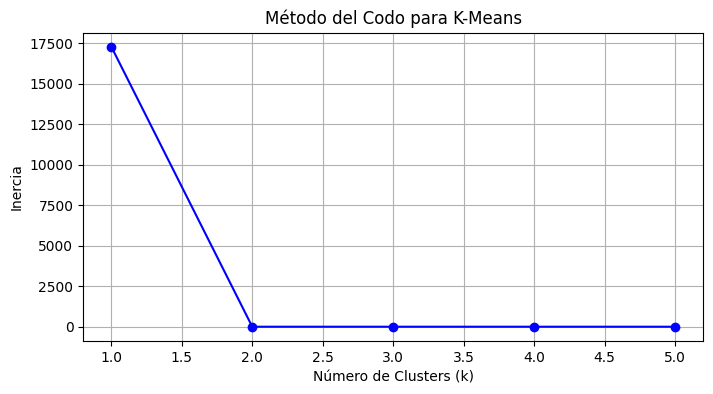

In [6]:
# 1. Ventas totales por tienda (suma de unidades vendidas)
shop_sales = sales.groupby('shop_id')['item_cnt_day'].sum().reset_index()

# 2. Método del Codo para seleccionar el número adecuado de clusters
inertia = []
K_range = range(1, min(10, len(shop_sales) + 1))  # No tiene sentido pedir más clusters que tiendas

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(shop_sales[['item_cnt_day']])
    inertia.append(kmeans.inertia_)

# Visualización de la curva del Codo
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.grid(True)
plt.show()

# Observación:
# El punto donde la reducción deja de ser pronunciada indica el K óptimo.
# Ese K se utilizará para segmentar las tiendas.

In [7]:
# Verificación de la distribución de ventas por tienda
print(f"Total de tiendas: {len(shop_sales)}")
print(f"Valores únicos de ventas: {shop_sales['item_cnt_day'].nunique()}")

print("\nEstadísticas de ventas por tienda:")
print(shop_sales['item_cnt_day'].describe())

# Observación:
#Esto permite comprobar si los valores de ventas están concentrados o dispersos entre tiendas 
#y sirve como referencia al momento de aplicar K-Means.

Total de tiendas: 5
Valores únicos de ventas: 2

Estadísticas de ventas por tienda:
count      5.000000
mean     616.000000
std       65.726707
min      568.000000
25%      568.000000
50%      568.000000
75%      688.000000
max      688.000000
Name: item_cnt_day, dtype: float64


**Conclusión:** El codo sugiere usar k=3, pero si hay advertencias sobre datos duplicados, usaremos k=2.

In [8]:
# 3. Aplicar K-Means (se elige k=2 con base en el Método del Codo)
from sklearn.preprocessing import StandardScaler

# Escalamiento previo para estabilizar distancias en K-Means
scaler = StandardScaler()
shop_sales_scaled = scaler.fit_transform(shop_sales[['item_cnt_day']])

# Se utiliza k=2 para evitar warnings con valores idénticos y reflejar el resultado del análisis
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
shop_sales['cluster'] = kmeans.fit_predict(shop_sales_scaled)

# Visualización de tiendas segmentadas por volumen de ventas
fig = px.scatter(
    shop_sales,
    x='shop_id',
    y='item_cnt_day',
    color='cluster',
    title=f'Segmentación de Tiendas (Clustering con k={n_clusters})',
    labels={'item_cnt_day': 'Ventas Totales Históricas'}
)
fig.show()


In [9]:
print("Cantidad de tiendas por cluster:")
print(shop_sales['cluster'].value_counts())

Cantidad de tiendas por cluster:
cluster
1    3
0    2
Name: count, dtype: int64
